In [1]:
!C:\Users\keyan\AppData\Local\Programs\Python\Python311\Scripts\pip.exe install pandas numpy matplotlib seaborn statsmodels

In [61]:
# If you haven't installed these libraries yet, uncomment the line below and run it.
# !pip install pandas numpy matplotlib seaborn statsmodels

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose


In [62]:
%matplotlib inline


In [63]:
# Load the data into a pandas DataFrame
# Ensure you replace 'path_to_data.csv' with the path to your actual data file
data = pd.read_csv(r'C:\Users\keyan\Downloads\HH NG spot price MONTH.csv')

# Check the first few rows to ensure data is loaded correctly
#print(data.head())

# Convert the 'Date' column to datetime format and set it as the index
data['Date'] = pd.to_datetime(data['Date'], format='%b-%y')
data.set_index('Date', inplace=True)

# Check for missing values
missing_values = data.isnull().sum()
#print("\nMissing Values:\n", missing_values)

# Handle missing values if any (e.g., using forward fill method)
data.ffill(inplace=True)

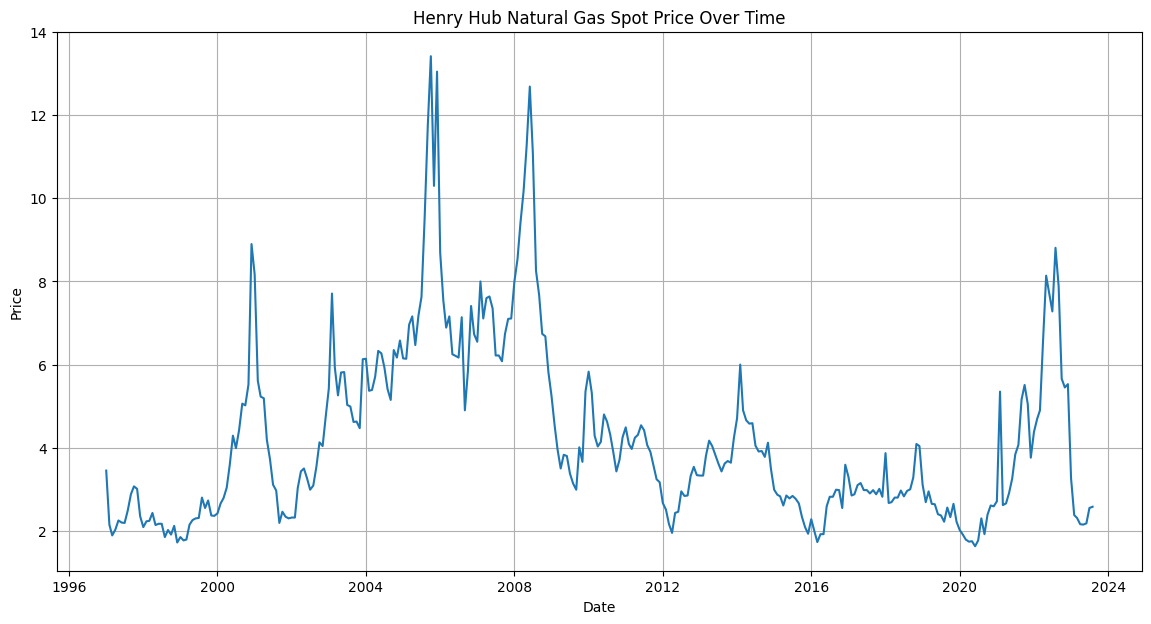

In [64]:
# Plot the data to visualize the price trend using matplotlib.pyplot
plt.figure(figsize=(14,7))
plt.plot(data['Henry Hub Natural Gas Spot Price '])
data.rename(columns={'Henry Hub Natural Gas Spot Price ': 'Price'}, inplace=True)
plt.title('Henry Hub Natural Gas Spot Price Over Time')
plt.xlabel('Date')
plt.ylabel('Price')
plt.grid(True)
plt.show()


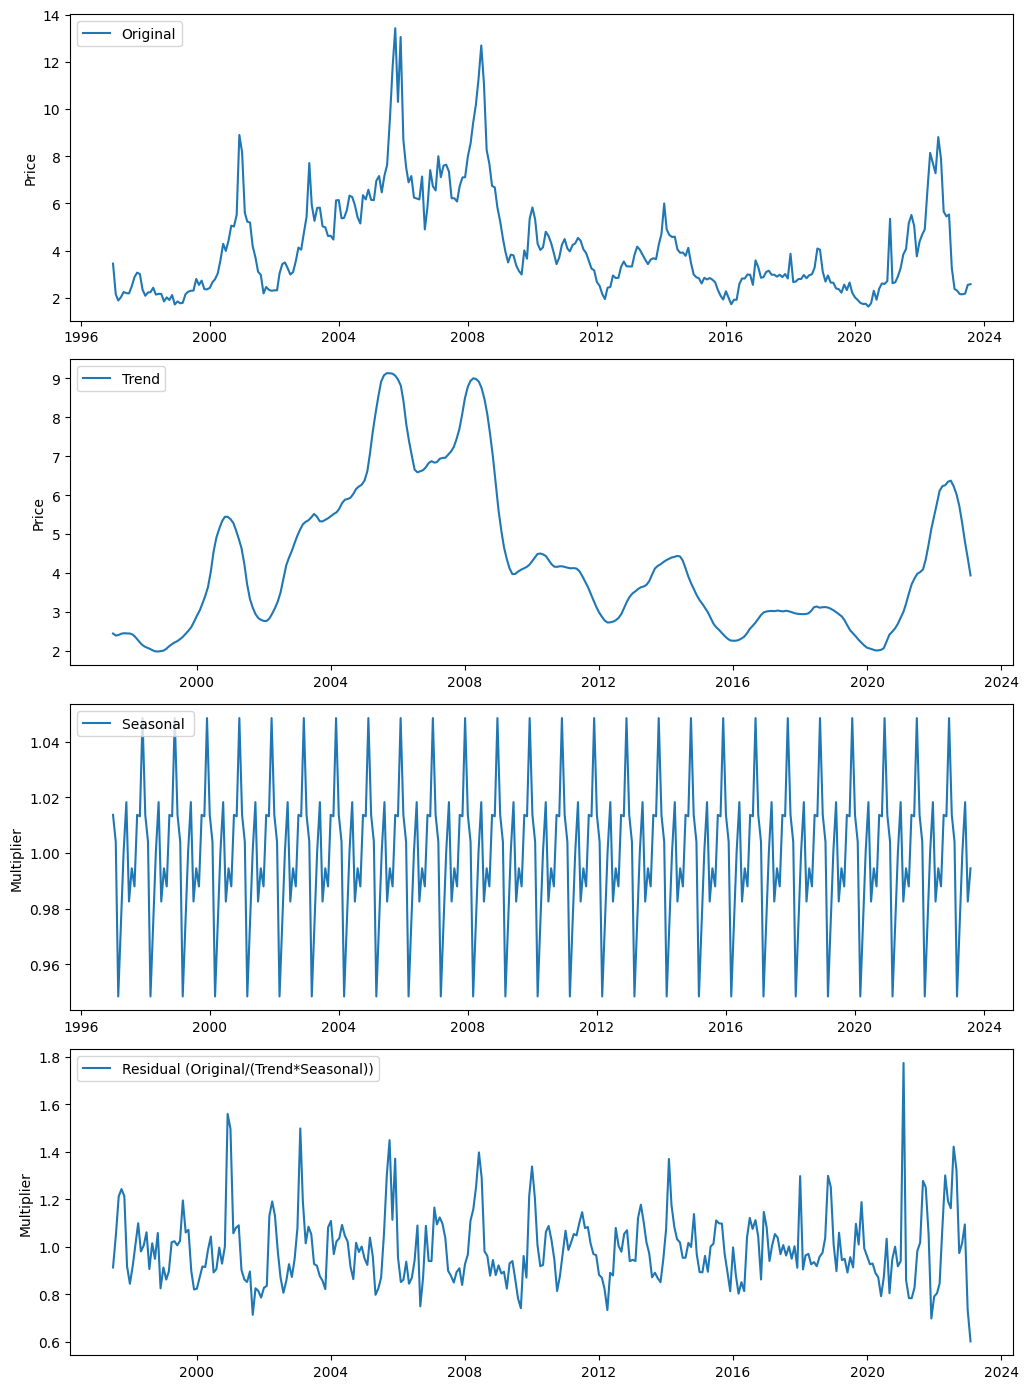

In [65]:
# Useing statsmodels, decompose, and matplotlib.pyplot to visually dissect different aspects of NGHH spot price graph

# Decompose using the additive model
decomposition_additive = seasonal_decompose(data['Price'], model='additive')
trend_additive = decomposition_additive.trend
seasonal_additive = decomposition_additive.seasonal
residual_additive = decomposition_additive.resid

# Decompose using the multiplicative model
decomposition_multiplicative = seasonal_decompose(data['Price'], model='multiplicative')
trend_multiplicative = decomposition_multiplicative.trend
seasonal_multiplicative = decomposition_multiplicative.seasonal
residual_multiplicative = decomposition_multiplicative.resid

# Plotting the decomposed time series components for comparison
plt.figure(figsize=(20,14))

# Original Data
plt.subplot(421)
plt.plot(data['Price'], label='Original')
plt.ylabel('Price')
plt.legend(loc='upper left')

# Trend
plt.subplot(423)
plt.plot(trend_multiplicative, label='Trend')
plt.ylabel('Price')
plt.legend(loc='upper left')

# Seasonal
plt.subplot(425)
plt.plot(seasonal_multiplicative, label='Seasonal ')
plt.ylabel('Multiplier')
plt.legend(loc='upper left')

# Residual
plt.subplot(427)
plt.plot(residual_multiplicative, label='Residual (Original/(Trend*Seasonal))')
plt.ylabel('Multiplier')
plt.legend(loc='upper left')

plt.tight_layout()



Highest Residual Months:
Date: 2021-02-01 00:00:00, Residual Value: 1.7741225014223296
Date: 2000-12-01 00:00:00, Residual Value: 1.5596214338207584
Date: 2003-02-01 00:00:00, Residual Value: 1.498734611650706
Date: 2001-01-01 00:00:00, Residual Value: 1.497439925790419
Date: 2005-10-01 00:00:00, Residual Value: 1.4494143203011867
Date: 2022-08-01 00:00:00, Residual Value: 1.4221062682794368
Date: 2008-06-01 00:00:00, Residual Value: 1.3978872074847593
Date: 2005-12-01 00:00:00, Residual Value: 1.3715284221507735
Date: 2014-02-01 00:00:00, Residual Value: 1.3702265681350454
Date: 2010-01-01 00:00:00, Residual Value: 1.3384623801895708
Date: 2022-09-01 00:00:00, Residual Value: 1.3237364128355145
Date: 2005-09-01 00:00:00, Residual Value: 1.3016453256371505
Date: 2022-05-01 00:00:00, Residual Value: 1.3009983861302488
Date: 2018-11-01 00:00:00, Residual Value: 1.2991078805895993
Date: 2018-01-01 00:00:00, Residual Value: 1.2980469922849198
Date: 2008-07-01 00:00:00, Residual Value: 1.29

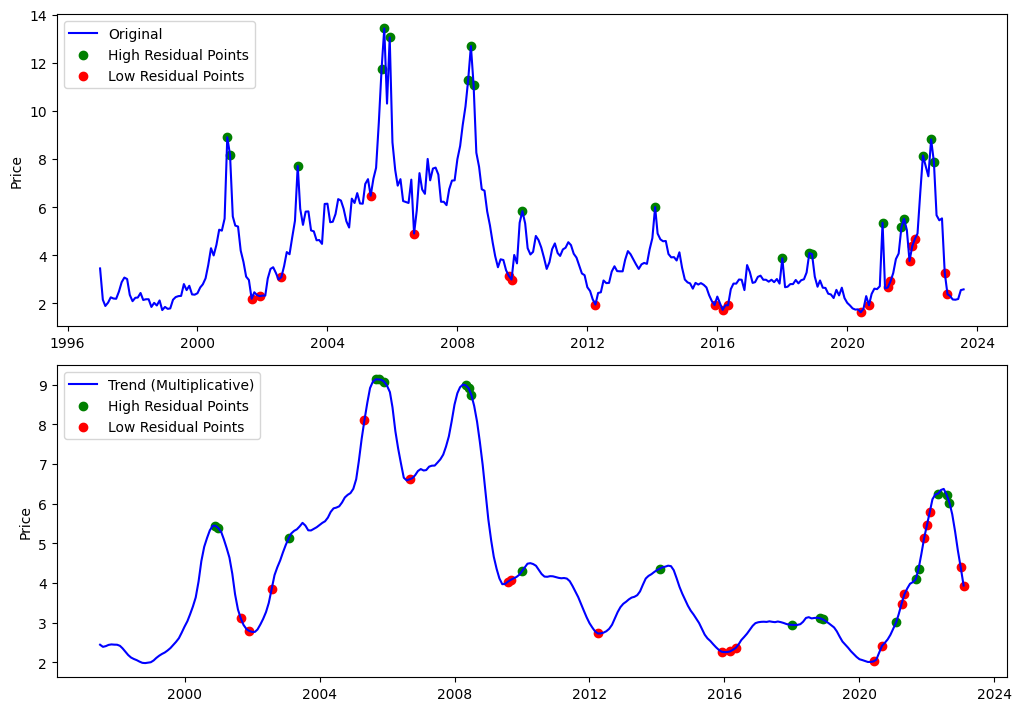

In [66]:
# Identify the 5 highest and 5 lowest residual months
highest_residual_dates = residual_multiplicative.sort_values(ascending=False).head(20).index
highest_residual_values = residual_multiplicative.sort_values(ascending=False).head(20).values

lowest_residual_dates = residual_multiplicative.sort_values(ascending=True).head(20).index
lowest_residual_values = residual_multiplicative.sort_values(ascending=True).head(20).values

# Plotting the decomposed time series components for comparison
plt.figure(figsize=(20,14))

# Original Data with high and low residual points
plt.subplot(421)
plt.plot(data['Price'], label='Original', color='blue')
plt.scatter(highest_residual_dates, data['Price'].loc[highest_residual_dates], color='green', label='High Residual Points')
plt.scatter(lowest_residual_dates, data['Price'].loc[lowest_residual_dates], color='red', label='Low Residual Points')
plt.ylabel('Price')
plt.legend(loc='upper left')

# Trend with high and low residual points
plt.subplot(423)
plt.plot(trend_multiplicative, label='Trend (Multiplicative)', color='blue')
plt.scatter(highest_residual_dates, trend_multiplicative.loc[highest_residual_dates], color='green', label='High Residual Points')
plt.scatter(lowest_residual_dates, trend_multiplicative.loc[lowest_residual_dates], color='red', label='Low Residual Points')
plt.ylabel('Price')
plt.legend(loc='upper left')

plt.tight_layout()

# Print the 5 highest and 5 lowest residual months along with their residual values
print("Highest Residual Months:")
for date, value in zip(highest_residual_dates, highest_residual_values):
    print(f"Date: {date}, Residual Value: {value}")

print("\nLowest Residual Months:")
for date, value in zip(lowest_residual_dates, lowest_residual_values):
    print(f"Date: {date}, Residual Value: {value}")


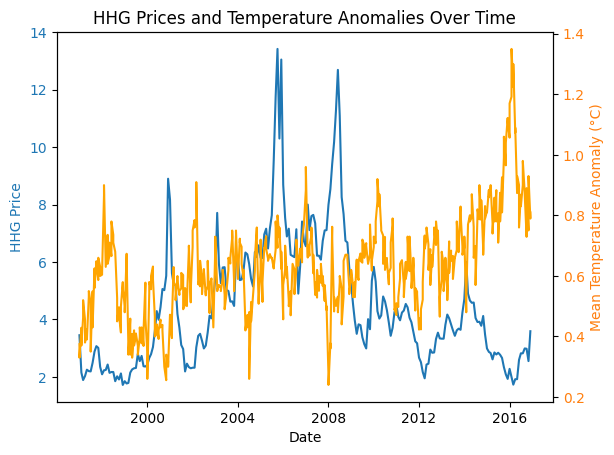

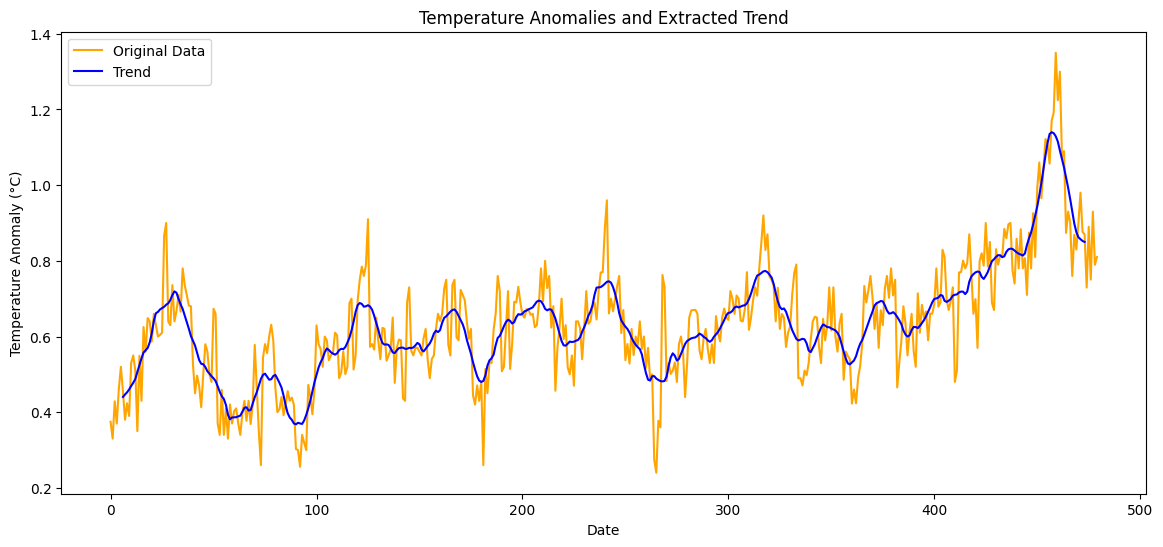

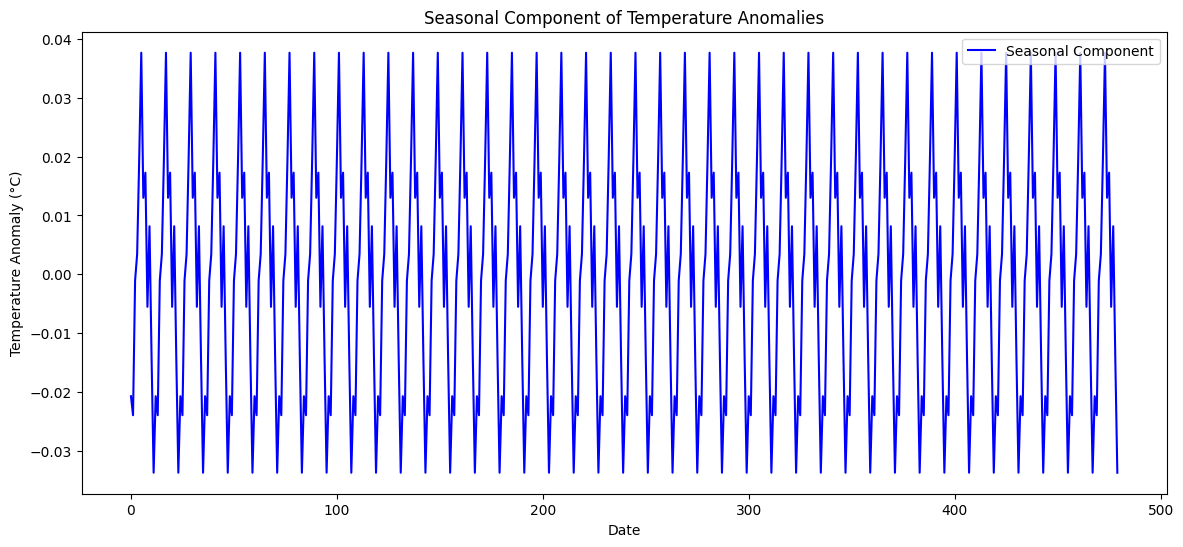

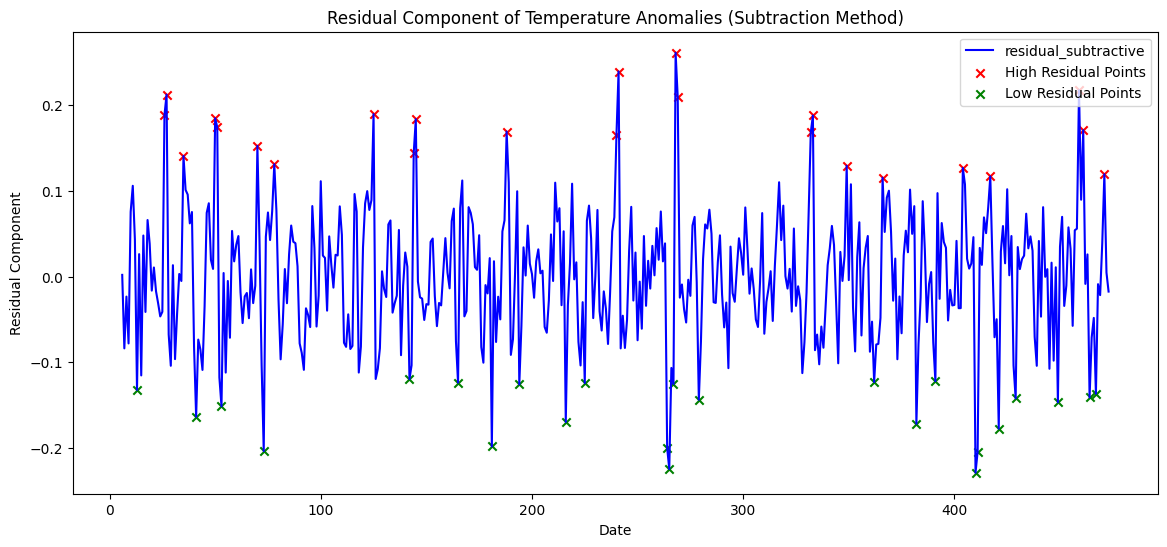

<Figure size 640x480 with 0 Axes>

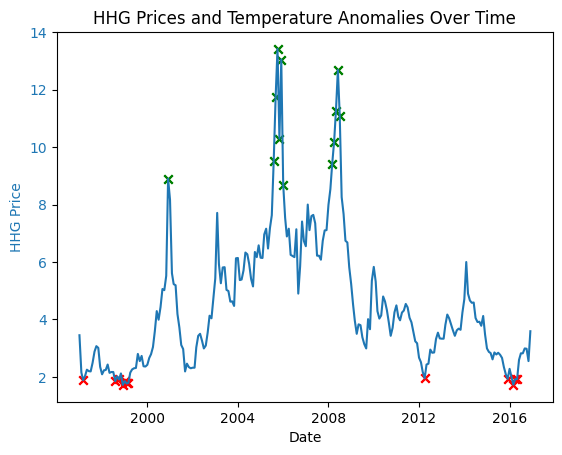

In [102]:
import pandas as pd
import matplotlib.pyplot as plt

# Read and preprocess HHG data
hhg_df = pd.read_csv(r'C:\Users\keyan\Downloads\HH NG spot price MONTH.csv')
hhg_df.columns = hhg_df.columns.str.strip()
hhg_df = hhg_df.rename(columns={'Date': 'Date_HHG', 'Henry Hub Natural Gas Spot Price': 'HHG_Price'})
hhg_df['Date_HHG'] = pd.to_datetime(hhg_df['Date_HHG'], format='%b-%y')

# Read and preprocess Temperature data
temp_df = pd.read_csv(r'C:\Users\keyan\Downloads\monthly (1).csv')
temp_df = temp_df.rename(columns={'Date': 'Date_Temp', 'Mean': 'Temp_Anomaly'})
temp_df['Date_Temp'] = pd.to_datetime(temp_df['Date_Temp'], format='%Y-%m')

# Filter data to include only from 1995 to present
hhg_df = hhg_df[hhg_df['Date_HHG'] >= '1995-01-01']
temp_df = temp_df[temp_df['Date_Temp'] >= '1995-01-01']

# Merge datasets on Date
merged_df = pd.merge(hhg_df, temp_df, left_on='Date_HHG', right_on='Date_Temp', how='inner')

# Filter merged data to make sure it starts from 1995
merged_df = merged_df[merged_df['Date_HHG'] >= '1995-01-01']
merged_df = merged_df[merged_df['Date_Temp'] >= '1995-01-01']

# Calculate residuals for HHG prices
merged_df['Residual'] = merged_df['HHG_Price'] - merged_df['HHG_Price'].mean()



# Identify high and low residual points
high_residual_points = merged_df[merged_df['Residual'] > merged_df['Residual'].quantile(0.95)]
low_residual_points = merged_df[merged_df['Residual'] < merged_df['Residual'].quantile(0.05)]

# Create the plot
fig, ax1 = plt.subplots()

# Plot HHG prices
ax1.set_xlabel('Date')
ax1.set_ylabel('HHG Price', color='tab:blue')
ax1.plot(merged_df['Date_HHG'], merged_df['HHG_Price'], color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# Highlight high and low residual points
#ax1.scatter(high_residual_points['Date_HHG'], high_residual_points['HHG_Price'], color='red')
#ax1.scatter(low_residual_points['Date_HHG'], low_residual_points['HHG_Price'], color='green')

# Create a second y-axis for temperature anomalies
ax2 = ax1.twinx()
ax2.set_ylabel('Mean Temperature Anomaly (°C)', color='tab:orange')
ax2.plot(merged_df['Date_HHG'], merged_df['Temp_Anomaly'], color='orange')
ax2.tick_params(axis='y', labelcolor='tab:orange')

# Show the plot
plt.title('HHG Prices and Temperature Anomalies Over Time')
plt.show()

# Correcting the parameter name from 'freq' to 'period' for seasonal decomposition
decomposition = seasonal_decompose(temp_analysis_df['Temp_Anomaly'], period=12)  # Using monthly frequency

# Extracting the trend component
trend = decomposition.trend.dropna()

# Plotting the original data along with the extracted trend
plt.figure(figsize=(14, 6))
plt.plot(temp_analysis_df['Temp_Anomaly'], label='Original Data', color='orange')
plt.plot(trend, label='Trend', color='blue')
plt.xlabel('Date')
plt.ylabel('Temperature Anomaly (°C)')
plt.title('Temperature Anomalies and Extracted Trend')
plt.legend()
plt.show()

# Perform seasonal decomposition to extract the seasonal component
seasonal = decomposition.seasonal.dropna()

# Plot the seasonal component
plt.figure(figsize=(14, 6))
plt.plot(seasonal, label='Seasonal Component', color='blue')
plt.xlabel('Date')
plt.ylabel('Temperature Anomaly (°C)')
plt.title('Seasonal Component of Temperature Anomalies')
plt.legend()
plt.show()

# Calculate the residual component by subtracting the seasonal and trend components from the original data
# Note: We have to align the indices because the trend and seasonal components have NaNs at the beginning and end
residual_subtract = aligned_temp_data - (seasonal + trend)

# Identify significant residual points
high_residual_points_subtract = residual_subtract[residual_subtract > residual_subtract.quantile(0.95)]
low_residual_points_subtract = residual_subtract[residual_subtract < residual_subtract.quantile(0.05)]

# Create the plot for the residual component calculated using subtraction
plt.figure(figsize=(14, 6))
plt.plot(residual_subtract, label='residual_subtractive', color='blue')
plt.scatter(high_residual_points_subtract.index, high_residual_points_subtract, color='red', label='High Residual Points',marker='x')
plt.scatter(low_residual_points_subtract.index, low_residual_points_subtract, color='green', label='Low Residual Points',marker='x')
plt.xlabel('Date')
plt.ylabel('Residual Component')
plt.title('Residual Component of Temperature Anomalies (Subtraction Method)')
plt.legend()
plt.show()

plt.tight_layout()

# Read and preprocess HHG data
hhg_df = pd.read_csv(r'C:\Users\keyan\Downloads\HH NG spot price MONTH.csv')
hhg_df.columns = hhg_df.columns.str.strip()
hhg_df = hhg_df.rename(columns={'Date': 'Date_HHG', 'Henry Hub Natural Gas Spot Price': 'HHG_Price'})
hhg_df['Date_HHG'] = pd.to_datetime(hhg_df['Date_HHG'], format='%b-%y')

# Read and preprocess Temperature data
temp_df = pd.read_csv(r'C:\Users\keyan\Downloads\monthly (1).csv')
temp_df = temp_df.rename(columns={'Date': 'Date_Temp', 'Mean': 'Temp_Anomaly'})
temp_df['Date_Temp'] = pd.to_datetime(temp_df['Date_Temp'], format='%Y-%m')

# Filter data to include only from 1995 to present
hhg_df = hhg_df[hhg_df['Date_HHG'] >= '1995-01-01']
temp_df = temp_df[temp_df['Date_Temp'] >= '1995-01-01']

# Merge datasets on Date
merged_df = pd.merge(hhg_df, temp_df, left_on='Date_HHG', right_on='Date_Temp', how='inner')

# Filter merged data to make sure it starts from 1995
merged_df = merged_df[merged_df['Date_HHG'] >= '1995-01-01']
merged_df = merged_df[merged_df['Date_Temp'] >= '1995-01-01']

# Calculate residuals for HHG prices
merged_df['Residual'] = merged_df['HHG_Price'] - merged_df['HHG_Price'].mean()



# Identify high and low residual points
high_residual_points = merged_df[merged_df['Residual'] > merged_df['Residual'].quantile(0.95)]
low_residual_points = merged_df[merged_df['Residual'] < merged_df['Residual'].quantile(0.05)]

# Create the plot
fig, ax1 = plt.subplots()

# Plot HHG prices
ax1.set_xlabel('Date')
ax1.set_ylabel('HHG Price', color='tab:blue')
ax1.plot(merged_df['Date_HHG'], merged_df['HHG_Price'], color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# Highlight high and low residual points
ax1.scatter(high_residual_points['Date_HHG'], high_residual_points['HHG_Price'], color='green',marker='x')
ax1.scatter(low_residual_points['Date_HHG'], low_residual_points['HHG_Price'], color='red',marker='x')

# Create a second y-axis for temperature anomalies

# Show the plot
plt.title('HHG Prices and Temperature Anomalies Over Time')
plt.show()
#make first graph longer /extended fully 

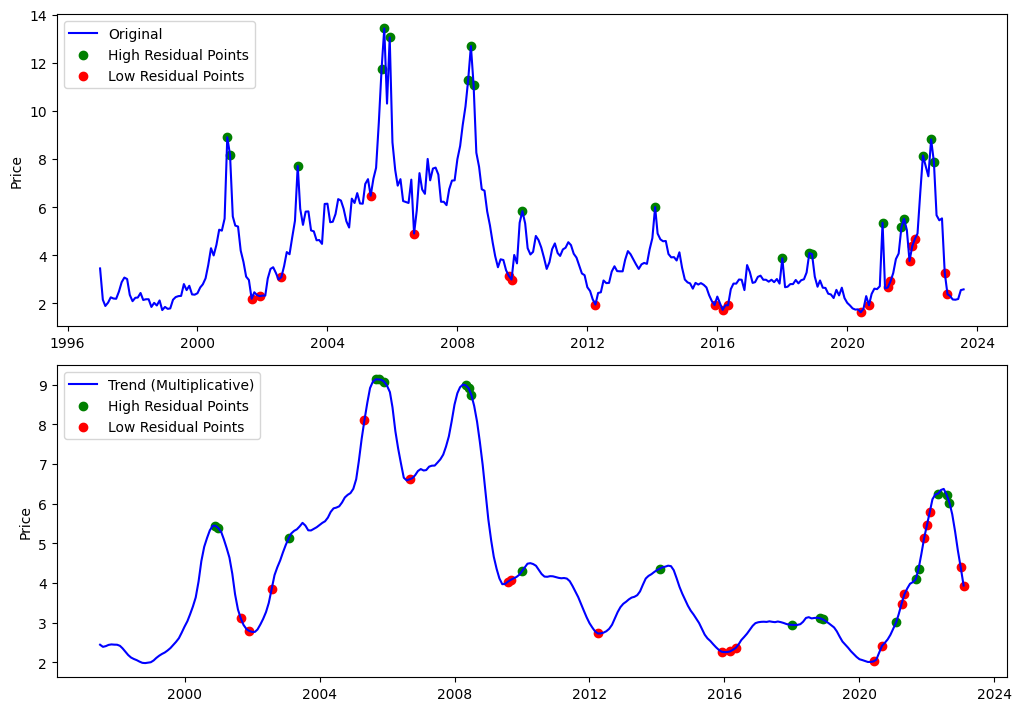